### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv

# Import the module
import networks
import utils

%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [4]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student = 'checkpoints_student_QAT/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)

### Load dataset

In [5]:
import torchvision
import torchvision.transforms as transforms
import PIL

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

import torchvision as tv
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### load pre-trained teacher network

In [6]:
import detectors
import timm

model = timm.create_model("resnet50_cifar10", pretrained=True)

model = model.to(fast_device)
# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(model, test_loader, fast_device)
print('test accuracy: ', test_accuracy)


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test accuracy:  0.9225


In [7]:
# another way load teacher
teacher_net = networks.TeacherNetwork50()

checkpoint = torch.load('resnet50_cifar10_pretrained.bin')

teacher_net.model.load_state_dict(checkpoint)
teacher_net.to(fast_device)

reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_10944\1025170478.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

test accuracy:  0.9225


### Student Network

#### Student Network (with training)

In [8]:
num_epochs = 200
print_every = 100

In [9]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)


In [43]:
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


checkpoints_path_student = 'checkpoints_student_QAT/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    prepared_student = torch.quantization.prepare_qat(student_net)
    prepared_student.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(prepared_student)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamMixup(
            teacher_net, prepared_student, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=True, checkpoint_save_path= checkpoints_path_student, resume_checkpoint=False,
            optimizer_choice='sgd'
        )

    training_time = time.time() - start_time
    prepared_student.eval()
    
    quantized_model = torch.quantization.convert(prepared_student)

    # Final model save
    final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device) # 'cpu'
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")


Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0.0
0.0 11173962 23520842
[Epoch 1, Batch 100/372] Train Loss: 12.237, Train Accuracy: 0.086
[Epoch 1, Batch 200/372] Train Loss: 4.760, Train Accuracy: 0.234
[Epoch 1, Batch 300/372] Train Loss: 7.098, Train Accuracy: 0.602
Epoch 1 Validation Accuracy: 0.640
[Epoch 2, Batch 100/372] Train Loss: 5.812, Train Accuracy: 0.727
[Epoch 2, Batch 200/372] Train Loss: 4.924, Train Accuracy: 0.086
[Epoch 2, Batch 300/372] Train Loss: 3.587, Train Accuracy: 0.328
Epoch 2 Validation Accuracy: 0.739
[Epoch 3, Batch 100/372] Train Loss: 2.799, Train Accuracy: 0.844
[Epoch 3, Batch 200/372] Train Loss: 2.914, Train Accuracy: 0.664
[Epoch 3, Batch 300/372] Train Loss: 2.755, Train Accuracy: 0.797
Epoch 3 Validation Accuracy: 0.800
[Epoch 4, Batch 100/372] Train Loss: 3.705, Train Accuracy: 0.336
[Epoch 4, Batch 200/372] Train Loss: 2.659, Train Accurac

RuntimeError: Unsupported qscheme: per_channel_affine

In [10]:
info = torch.load('checkpoints_student_QAT/T=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0_checkpoint_epoch_25.tar')

C:\Users\17598\AppData\Local\Temp\ipykernel_21196\3476845874.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load('checkpoints_student_QAT/T=4, alpha=1.0, d

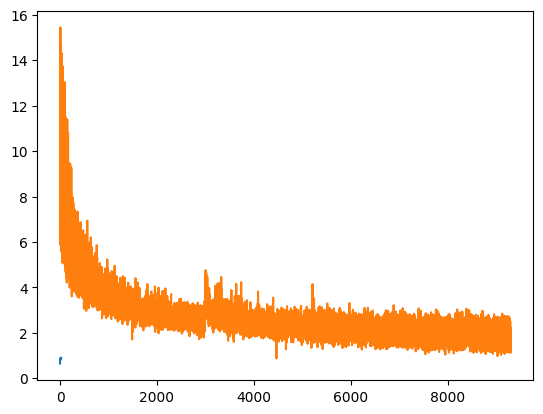

In [11]:
plt.plot(info['val_acc'])
plt.plot(info['train_loss'])

In [ ]:
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import fuse_modules

checkpoints = [x for x in range(25, 201, 25)]
test_accs = []

for cp in checkpoints:
    student_net = networks.StudentNetwork(Apruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    checkpoint = torch.load(f'checkpoints_student_QAT/T=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0_checkpoint_epoch_{cp}.tar')
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    student_net = torch.quantization.prepare_qat(student_net)
    
    student_net.load_state_dict(checkpoint['model_state_dict'])
    student_net.to(fast_device)
    student_net.eval()

    student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')

    student_net_prepared = torch.ao.quantization.prepare(student_net)

    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(fast_device)
            student_net_prepared(inputs)  # Run a forward pass to collect activation statistics
    student_net_prepared.to('cpu')

    student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
    reproducibilitySeed()
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_int8, test_loader, 'cpu')
    print('test accuracy: ', test_accuracy)
    test_accs.append(test_accuracy)

C:\Users\17598\AppData\Local\Temp\ipykernel_21196\1265263037.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'checkpoints_student_QAT/T=4, alpha

test accuracy:  0.896
test accuracy:  0.9161
test accuracy:  0.9178
test accuracy:  0.9196
test accuracy:  0.9227
test accuracy:  0.9195
test accuracy:  0.9226
test accuracy:  0.921


In [41]:
try:
    student_net.load_state_dict(checkpoint['model_state_dict'])
except RuntimeError as e:
    print("Encountered a RuntimeError:", e)
    print("Attempting to load state dict with strict=False")
    student_net.load_state_dict(checkpoint['model_state_dict'], strict=False)


Encountered a RuntimeError: Error(s) in loading state_dict for StudentNetwork:
	Missing key(s) in state_dict: "model.model.conv1.0.weight", "model.model.conv1.1.weight", "model.model.conv1.1.bias", "model.model.conv1.1.running_mean", "model.model.conv1.1.running_var", "model.model.layer1.0.conv1.0.weight", "model.model.layer1.0.conv1.1.weight", "model.model.layer1.0.conv1.1.bias", "model.model.layer1.0.conv1.1.running_mean", "model.model.layer1.0.conv1.1.running_var", "model.model.layer1.0.conv2.0.weight", "model.model.layer1.0.conv2.1.weight", "model.model.layer1.0.conv2.1.bias", "model.model.layer1.0.conv2.1.running_mean", "model.model.layer1.0.conv2.1.running_var", "model.model.layer1.1.conv1.0.weight", "model.model.layer1.1.conv1.1.weight", "model.model.layer1.1.conv1.1.bias", "model.model.layer1.1.conv1.1.running_mean", "model.model.layer1.1.conv1.1.running_var", "model.model.layer1.1.conv2.0.weight", "model.model.layer1.1.conv2.1.weight", "model.model.layer1.1.conv2.1.bias", "mod

## Attention

In [10]:
# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
pruning_factor = 0


checkpoints_path_student = 'checkpoints_student/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparam['dist_ratio'] = 0.5,
    hparam['angle_ratio'] = 0.5
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    prepared_student = torch.quantization.prepare_qat(student_net)
    prepared_student.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)

    # Count parameters
    student_params_num = count_parameters(prepared_student)
    
    print(pruning_factor, student_params_num, count_parameters(teacher_net))
    results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamAT(
            teacher_net, prepared_student, hparam, num_epochs,
            train_loader, val_loader,
            print_every=print_every,
            fast_device=fast_device, quant=True, checkpoint_save_path= checkpoints_path_student, resume_checkpoint=False,
            optimizer_choice='sgd'
        )

    training_time = time.time() - start_time
    prepared_student.eval()
    
    quantized_model = torch.quantization.convert(prepared_student)

    # Final model save
    final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
    torch.save({
        'results': results_distill[(hparam_tuple, pruning_factor)],
        'model_state_dict': quantized_model.state_dict(),
        'epoch': num_epochs
    }, final_save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device) # 'cpu'
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")


Training with hparamsT=4, alpha=1.0, angle_ratio=0.5, dist_ratio=(0.5,), dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


0 11173962 23520842
Epoch 1, Batch 100: Loss = 10.8462
Epoch 1, Batch 200: Loss = 7.9141
Epoch 1, Batch 300: Loss = 6.9008
Epoch 1: Validation Loss = 1.0877, Validation Accuracy = 0.63%
Epoch 2, Batch 100: Loss = 5.4554
Epoch 2, Batch 200: Loss = 4.1714
Epoch 2, Batch 300: Loss = 4.5779
Epoch 2: Validation Loss = 0.7812, Validation Accuracy = 0.72%
Epoch 3, Batch 100: Loss = 4.5319
Epoch 3, Batch 200: Loss = 3.5200
Epoch 3, Batch 300: Loss = 3.8894
Epoch 3: Validation Loss = 0.6203, Validation Accuracy = 0.79%
Epoch 4, Batch 100: Loss = 3.0337
Epoch 4, Batch 200: Loss = 3.8023
Epoch 4, Batch 300: Loss = 3.1403
Epoch 4: Validation Loss = 0.5890, Validation Accuracy = 0.80%
Epoch 5, Batch 100: Loss = 3.4799
Epoch 5, Batch 200: Loss = 3.7533
Epoch 5, Batch 300: Loss = 3.2624
Epoch 5: Validation Loss = 0.5326, Validation Accuracy = 0.82%
Epoch 6, Batch 100: Loss = 4.0533
Epoch 6, Batch 200: Loss = 3.9168
Epoch 6, Batch 300: Loss = 4.1164
Epoch 6: Validation Loss = 0.4839, Validation Accura

KeyboardInterrupt: 

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_10944\538120021.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

test accuracy:  0.8745
test accuracy:  0.8901
test accuracy:  0.8906
test accuracy:  0.89


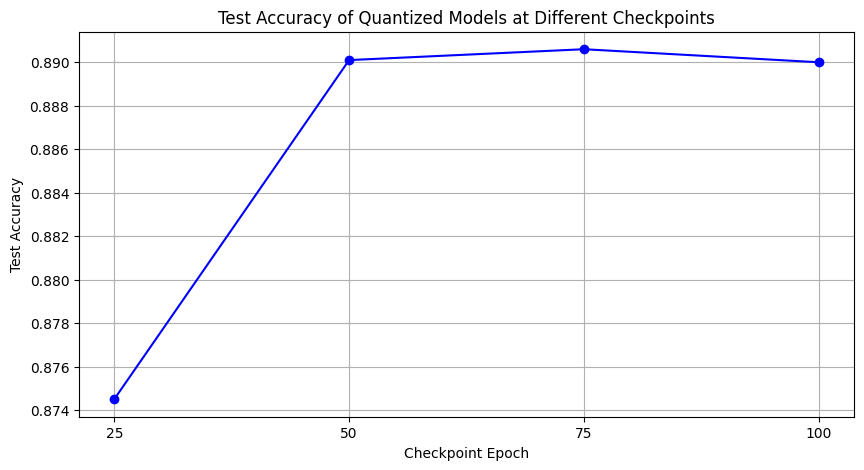

In [9]:
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import fuse_modules

checkpoints = [x for x in range(25, 101, 25)]
test_accs = []

for cp in checkpoints:
    student_net = networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    checkpoint = torch.load(f'checkpoints_student/checkpoint_epoch_{cp}.pth')
    student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
    student_net = torch.quantization.prepare_qat(student_net)
    
    student_net.load_state_dict(checkpoint['model_state_dict'])
    student_net.to(fast_device)
    student_net.eval()

    student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')

    student_net_prepared = torch.ao.quantization.prepare(student_net)

    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(fast_device)
            student_net_prepared(inputs)  # Run a forward pass to collect activation statistics
    student_net_prepared.to(fast_device)

    #student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
    reproducibilitySeed()
    _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_prepared, test_loader, fast_device)
    print('test accuracy: ', test_accuracy)
    test_accs.append(test_accuracy)

# Plotting the test accuracies
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, test_accs, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy of Quantized Models at Different Checkpoints')
plt.xlabel('Checkpoint Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.xticks(checkpoints)
plt.show()


### DML

In [23]:

# Setup for the hyperparameters and training configurations
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
pruning_factor = 0

checkpoints_path_student = 'checkpoints_student/'

# Generate all combinations of hyperparameters
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'alpha': hparam_tuple[0],
        'T': hparam_tuple[1],
        'dropout_input': hparam_tuple[2][0],
        'dropout_hidden': hparam_tuple[2][1],
        'weight_decay': hparam_tuple[3],
        'lr_decay': hparam_tuple[4],
        'momentum': hparam_tuple[5],
        'lr': hparam_tuple[6]
    }
    hparams_list.append(hparam)

# Training and logging setup
csv_file = os.path.join(checkpoints_path_student, "results_student.csv")
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Create multiple student models and their optimizers
student_models = [networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True),  networks.StudentNetwork(pruning_factor=0.0, teacher_net = teacher_net, q=True, fuse=True, qat=True, dif_arch=True)]  # Create multiple instances for DML
optimizers = [optim.SGD(student.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0) for student in student_models]

def trainDML(student_models, hparam, num_epochs, train_loader, val_loader, optimizers, fast_device=torch.device('cuda:0')):
    for student in student_models:
        student.to(fast_device).train()

    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for data, labels in train_loader:
            data, labels = data.to(fast_device), labels.to(fast_device)

            # Zero the parameter gradients for all optimizers at the start of the batch processing
            for optimizer in optimizers:
                optimizer.zero_grad()

            outputs = [student(data) for student in student_models]
            losses = []

            # Calculate losses for all students but do not yet backpropagate
            for i, student_output in enumerate(outputs):
                loss = criterion(student_output, labels)  # Standard classification loss
                dml_loss = sum(F.mse_loss(F.softmax(student_output, dim=1), F.softmax(other_output, dim=1))
                               for j, other_output in enumerate(outputs) if i != j)
                total_loss = loss + dml_loss / (len(student_models) - 1)  # Normalize DML loss
                losses.append(total_loss)

            # Now backpropagate for all students
            for i, loss in enumerate(losses):
                loss.backward(retain_graph=True if i < len(student_models) - 1 else False)  # Retain graph for all but last loss

            # Step the optimizers after all gradients are calculated
            for optimizer in optimizers:
                optimizer.step()

        if (epoch + 1) % 25 == 0:
            for idx, student in enumerate(student_models):
                torch.save(student.state_dict(), f"{checkpoints_path_student}student_{idx}_epoch_{epoch}.pth")
                print(f"Checkpoint saved for Student {idx} at Epoch {epoch + 1}: {checkpoints_path_student}student_{idx}_epoch_{epoch}.pth")

        # Add validation and additional logging as necessary

    print("Training completed.")

# Make sure to call this function with the correct parameters and dataloaders
trainDML(student_models, hparam, 200, train_loader, val_loader, optimizers)
# Further steps such as evaluation and logging results to CSV as shown above

Checkpoint saved for Student 0 at Epoch 25: checkpoints_student/student_0_epoch_24.pth
Checkpoint saved for Student 1 at Epoch 25: checkpoints_student/student_1_epoch_24.pth
Checkpoint saved for Student 0 at Epoch 50: checkpoints_student/student_0_epoch_49.pth
Checkpoint saved for Student 1 at Epoch 50: checkpoints_student/student_1_epoch_49.pth
Checkpoint saved for Student 0 at Epoch 75: checkpoints_student/student_0_epoch_74.pth
Checkpoint saved for Student 1 at Epoch 75: checkpoints_student/student_1_epoch_74.pth
Checkpoint saved for Student 0 at Epoch 100: checkpoints_student/student_0_epoch_99.pth
Checkpoint saved for Student 1 at Epoch 100: checkpoints_student/student_1_epoch_99.pth
Checkpoint saved for Student 0 at Epoch 125: checkpoints_student/student_0_epoch_124.pth
Checkpoint saved for Student 1 at Epoch 125: checkpoints_student/student_1_epoch_124.pth
Checkpoint saved for Student 0 at Epoch 150: checkpoints_student/student_0_epoch_149.pth
Checkpoint saved for Student 1 at E

Evaluating checkpoint at epoch 25


C:\Users\17598\AppData\Local\Temp\ipykernel_13036\869396217.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=fast_d

Student 1 test accuracy at epoch 25: 0.8892%
Student 2 test accuracy at epoch 25: 0.8851%
Evaluating checkpoint at epoch 50
Student 1 test accuracy at epoch 50: 0.8898%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000014BB5711630>
Traceback (most recent call last):
  File "c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Student 2 test accuracy at epoch 50: 0.8902%
Evaluating checkpoint at epoch 75
Student 1 test accuracy at epoch 75: 0.894%
Student 2 test accuracy at epoch 75: 0.893%
Evaluating checkpoint at epoch 100
Student 1 test accuracy at epoch 100: 0.8985%
Student 2 test accuracy at epoch 100: 0.8973%
Evaluating checkpoint at epoch 125
Student 1 test accuracy at epoch 125: 0.8934%
Student 2 test accuracy at epoch 125: 0.8891%
Evaluating checkpoint at epoch 150
Student 1 test accuracy at epoch 150: 0.8973%
Student 2 test accuracy at epoch 150: 0.8937%
Evaluating checkpoint at epoch 175
Student 1 test accuracy at epoch 175: 0.8978%
Student 2 test accuracy at epoch 175: 0.8981%
Evaluating checkpoint at epoch 200
Student 1 test accuracy at epoch 200: 0.8968%
Student 2 test accuracy at epoch 200: 0.8982%


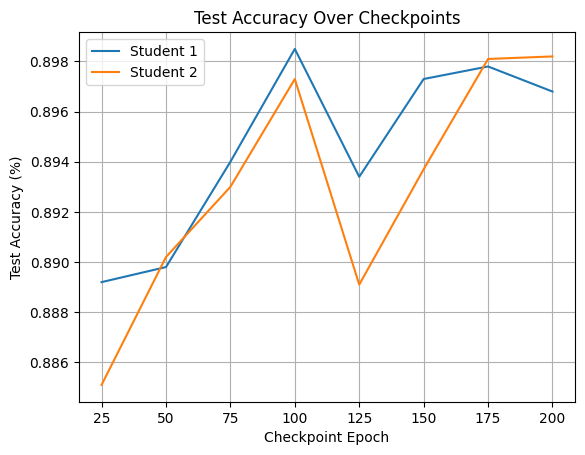

In [44]:
from torch.quantization import QuantStub, DeQuantStub
from torch.quantization import fuse_modules
import torch
import matplotlib.pyplot as plt

checkpoints = [x for x in range(25, 201, 25)]
students_count = 2  # Assuming there are two students in DML
test_accs = {i: [] for i in range(students_count)}  # Dictionary to store accuracies for each student

for cp in checkpoints:
    print(f"Evaluating checkpoint at epoch {cp}")
    for student_index in range(students_count):
        student_net = networks.StudentNetwork(pruning_factor=0.0, teacher_net=teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
        checkpoint_path = f'checkpoints_student/student_{student_index}_epoch_{cp-1}.pth'
        checkpoint = torch.load(checkpoint_path, map_location=fast_device)  # Ensure it loads on the correct device
        
        # Load the state dictionary directly since it's not under 'model_state_dict'
        student_net.load_state_dict(checkpoint)
        
        student_net.to(fast_device)
        student_net.eval()

        # Prepare and convert the network using the appropriate quantization configuration
        student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')
        student_net_prepared = torch.ao.quantization.prepare(student_net, inplace=False)

        with torch.no_grad():
            for inputs, _ in train_loader:
                inputs = inputs.to(fast_device)
                student_net_prepared(inputs)  # Calibrate with some forward passes

        #student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
        reproducibilitySeed()
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_prepared, test_loader, fast_device)
        print(f'Student {student_index + 1} test accuracy at epoch {cp}: {test_accuracy}%')
        test_accs[student_index].append(test_accuracy)

# Plotting accuracies for each student
for student_index, accuracies in test_accs.items():
    plt.plot(checkpoints, accuracies, label=f'Student {student_index + 1}')

plt.title('Test Accuracy Over Checkpoints')
plt.xlabel('Checkpoint Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
import torch
import matplotlib.pyplot as plt

# Assuming you've defined a model class 'StudentNetwork'
def load_and_quantize_model(checkpoint_path, device):
    # Instantiate the model
    student_net = networks.StudentNetwork(pruning_factor=0.0, teacher_net=teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
    
    # Load the model state dictionary
    checkpoint = torch.load(checkpoint_path, map_location=device)
    student_net.load_state_dict(checkpoint)
    
    student_net.to(device)
    student_net.eval()

    # Prepare for quantization
    student_net.qconfig = torch.ao.quantization.get_default_qconfig('x86')
    student_net_prepared = torch.ao.quantization.prepare(student_net, inplace=False)

    # Convert the model to quantized version
    try:
        student_net_int8 = torch.ao.quantization.convert(student_net_prepared)
    except RuntimeError as e:
        print(f"Error during conversion: {e}")
        return None

    return student_net_int8

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the saved model checkpoint
checkpoint_path = 'checkpoints_student/student_0_epoch_24.pth'

# Load and quantize the model
quantized_model = load_and_quantize_model(checkpoint_path, device)

if quantized_model:
    # You can now perform evaluation or further processing with your quantized model
    print("Quantization successful!")

C:\Users\17598\AppData\Local\Temp\ipykernel_13036\4265574020.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Error during conversion: Unsupported qscheme: per_channel_affine


#### Student Network (without training)

In [ ]:
# Define hyperparameter ranges
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.90]
dropout_probabilities = [(0.0, 0.0)]

# Prepare the list of hyperparameters
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'dropout_input': hparam_tuple[0][0],
        'dropout_hidden': hparam_tuple[0][1],
        'weight_decay': hparam_tuple[1],
        'lr_decay': hparam_tuple[2],
        'momentum': hparam_tuple[3],
        'lr': hparam_tuple[4]
    }
    hparams_list.append(hparam)

# Results dictionary
results = {}
pruning_factors = [i/20 for i in range(1, 20)]

# CSV file setup
csv_file = "checkpoints_student/results_student_wo.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Trainable Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training without hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net_wo = networks.StudentNetwork(pruning_factor, teacher_net)
        student_net_wo = student_net_wo.to(fast_device)
        #hparam_tuple = utils.hparamDictToTuple(hparam)

        # Count parameters
        student_params_num = count_parameters(student_net_wo)
        print(pruning_factor, student_params_num, count_parameters(teacher_net))

        # Train the student network
        #results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs,
                                                                                    #train_val_loader, None,
                                                                                    #print_every=print_every,
                                                                                    #fast_device=fast_device)

        training_time = time.time() - start_time

        # Save model
        #save_path = checkpoints_path_student + utils.hparamToString(hparam) + f'_pruning_{pruning_factor}_w/o_final.tar'
        #torch.save({
            #'results': results_distill[(hparam_tuple, pruning_factor)],
            #'model_state_dict': student_net.state_dict(),
            #'epoch': num_epochs
        #}, save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_wo, test_loader, fast_device)
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")

Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.05


c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.05 10623029 11181642
Test accuracy:  0.8617
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.1
0.1 10064428 11181642
Test accuracy:  0.8622
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.15
0.15 9505825 11181642
Test accuracy:  0.862
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.2
0.2 8947224 11181642
Test accuracy:  0.8614
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.25
0.25 8388631 11181642
Test accuracy:  0.8595
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.3
0.3 7830025 11181642
Test accuracy:  0.8583
Training withou